In [4]:
import os
import torch
# import kagglehub
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
from torch.amp import autocast
import pandas as pd
import polars as pl
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
def remove_gravity_from_acc(acc_data, rot_data):
    if isinstance(acc_data, pd.DataFrame):
        acc_values = acc_data[['acc_x', 'acc_y', 'acc_z']].values
    else:
        acc_values = acc_data
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data
    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)
    gravity_world = np.array([0, 0, 9.81])
    for i in range(num_samples):
        if np.all(np.isnan(quat_values[i])) or np.all(np.isclose(quat_values[i], 0)):
            linear_accel[i, :] = acc_values[i, :] 
            continue
        try:
            rotation = R.from_quat(quat_values[i])
            gravity_sensor_frame = rotation.apply(gravity_world, inverse=True)
            linear_accel[i, :] = acc_values[i, :] - gravity_sensor_frame
        except ValueError:
             linear_accel[i, :] = acc_values[i, :]
    return linear_accel

def calculate_angular_velocity_from_quat(rot_data, time_delta=1/200): # Assuming 200Hz sampling rate
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data
    num_samples = quat_values.shape[0]
    angular_vel = np.zeros((num_samples, 3))
    for i in range(num_samples - 1):
        q_t = quat_values[i]
        q_t_plus_dt = quat_values[i+1]
        if np.all(np.isnan(q_t)) or np.all(np.isclose(q_t, 0)) or \
           np.all(np.isnan(q_t_plus_dt)) or np.all(np.isclose(q_t_plus_dt, 0)):
            continue
        try:
            rot_t = R.from_quat(q_t)
            rot_t_plus_dt = R.from_quat(q_t_plus_dt)
            delta_rot = rot_t.inv() * rot_t_plus_dt
            angular_vel[i, :] = delta_rot.as_rotvec() / time_delta
        except ValueError:
            pass
    return angular_vel

def calculate_angular_distance(rot_data):
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data
    num_samples = quat_values.shape[0]
    angular_dist = np.zeros(num_samples)
    for i in range(num_samples - 1):
        q1 = quat_values[i]
        q2 = quat_values[i+1]
        if np.all(np.isnan(q1)) or np.all(np.isclose(q1, 0)) or \
           np.all(np.isnan(q2)) or np.all(np.isclose(q2, 0)):
            angular_dist[i] = 0
            continue
        try:
            r1 = R.from_quat(q1)
            r2 = R.from_quat(q2)
            relative_rotation = r1.inv() * r2
            angle = np.linalg.norm(relative_rotation.as_rotvec())
            angular_dist[i] = angle
        except ValueError:
            angular_dist[i] = 0 # В случае недействительных кватернионов
            pass
    return angular_dist

In [14]:
class CMIFeDataset(Dataset):
    def __init__(self, data_path, config):
        self.config = config
        self.init_feature_names(data_path)
        df = self.generate_features(pd.read_csv(data_path, usecols=set(self.use_cols) & set(self.raw_columns)))
        self.generate_dataset(df)

    def init_feature_names(self, data_path):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]

        self.acc_features = ['acc_mag', 'acc_mag_jerk', 'linear_acc_mag', 'linear_acc_mag_jerk']
        self.rot_features = ['rot_angle', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z', 'angular_distance']
        self.old_imu_features = [
            'acc_mag', 'rot_angle','acc_mag_jerk', 'rot_angle_vel',
            'linear_acc_mag', 'linear_acc_mag_jerk',
            'angular_vel_x', 'angular_vel_y', 'angular_vel_z', 'angular_distance'
        ]

        self.extra_imu_features = self.config.get("imu_feats", [])
        self.imu_features = self.extra_imu_features.copy()
        if self.config.get("add_imu_feat_default", True):
            if self.config.get("old_imu_feat", True):
                self.imu_features.extend(self.old_imu_features)
            else:
                self.imu_features.extend(self.acc_features)
                self.imu_features.extend(self.rot_features)
        self.er1_fearues = ["er_x", "er_y", "er_z"]
        self.er2_fearues = ['er_r_xy', 'er_r_xz', 'er_r_yz', 'er_c_xy', 'er_c_xz', 'er_c_yz']
        self.er_fearues = self.er1_fearues + self.er2_fearues
        self.tof_mode = self.config.get("tof_mode", "stats")
        self.tof_region_stats = ['mean', 'std', 'min', 'max']
        self.tof_cols = self.generate_tof_feature_names()

        self.raw_columns = pd.read_csv(data_path, nrows=0).columns.tolist()
        self.imu_acc_cols_base = ['acc_x', 'acc_y', 'acc_z', 'linear_acc_x', 'linear_acc_y', 'linear_acc_z'] if self.config.get("add_raw_acc", False) else ['linear_acc_x', 'linear_acc_y', 'linear_acc_z']
        self.imu_rot_cols_base = ['rot_w', 'rot_x', 'rot_y', 'rot_z']
        self.imu_cols_base = self.imu_acc_cols_base + self.imu_rot_cols_base
        self.imu_cols = list()
        self.imu_channel_keys = defaultdict(list)
        if self.config.get("add_imu_base", True): 
            self.imu_cols.extend(self.imu_cols_base)
            self.imu_channel_keys["acc"] = self.imu_acc_cols_base
            self.imu_channel_keys["rot"] = self.imu_rot_cols_base
        if self.config.get("add_imu_feats", True): 
            self.imu_cols.extend(self.imu_features)
            if self.config.get("split_imu_feat", False):
                if self.config.get("old_imu_feat", True):
                    assert False, "split_imu_feat=True and old_imu_feat=True not supported"
                self.imu_channel_keys["acc_feat"] = self.acc_features
                self.imu_channel_keys["rot_feat"] = self.rot_features
            else:
                if self.config.get("old_imu_feat", True):
                    self.imu_channel_keys["other"].extend(self.old_imu_features)
                else:
                    self.imu_channel_keys["other"].extend(self.acc_features)
                    self.imu_channel_keys["other"].extend(self.rot_features)
        if self.config.get("add_imu_er_feats", False): 
            self.imu_cols.extend(self.er_fearues)
            if self.config.get("split_imu_feat", False):
                self.imu_channel_keys["er1_feat"] = self.er1_fearues
                self.imu_channel_keys["er2_feat"] = self.er2_fearues
            else:
                self.imu_channel_keys["other"].extend(self.er1_fearues)
                self.imu_channel_keys["other"].extend(self.er2_fearues)
        self.flip_imu_cols = [f"{col}_flip" for col in self.imu_cols]
        self.imu_channel_keys = {k: sorted(v) for k, v in self.imu_channel_keys.items()}
        self.thm_cols = [c for c in self.raw_columns if c.startswith('thm_')]
        self.thm_channel_keys = {k: [f"thm_{k}"] for k in range(1, 6)}
        self.feature_cols = self.imu_cols + self.thm_cols + self.tof_cols
        self.imu_dim = len(self.imu_cols)
        self.thm_dim = len(self.thm_cols)
        self.tof_dim = len(self.tof_cols)
        self.base_cols = ['acc_x', 'acc_y', 'acc_z',
                          'rot_x', 'rot_y', 'rot_z', 'rot_w',
                          'sequence_id', 'subject', 
                          'sequence_type', 'gesture', 'orientation'] + [c for c in self.raw_columns if c.startswith('thm_')] + [f"tof_{i}_v{p}" for i in range(1, 6) for p in range(64)]
        self.use_cols = self.base_cols + self.feature_cols
        if self.config.get("return_flip_imu", False):
            self.use_cols.extend(self.flip_imu_cols)
        self.fold_cols = ['subject', 'sequence_type', 'gesture', 'orientation', 'sequence_id']
        if self.config.get("use_dg", False):
            self.dg_cols = ['adult_child', 'age', 'sex', 'handedness', 'shoulder_to_wrist_height', 'elbow_to_wrist_height']
        self.global_imu_indices = {k: sorted([self.imu_cols.index(feat) for feat in feats]) for k, feats in self.imu_channel_keys.items()}
        self.global_thm_indices = {k: sorted([self.thm_cols.index(key) for key in self.thm_channel_keys[k]]) for k in range(1, 6)}
        self.global_tof_indices = {k: sorted([self.tof_cols.index(key) for key in self.tof_channel_keys[k]]) for k in range(1, 6)}
            
    def generate_tof_feature_names(self):
        features = list()
        self.tof_channel_keys = defaultdict(list)
        if self.config.get("tof_raw", False):
            for i in range(1, 6):
                features.extend([f"tof_{i}_v{p}" for p in range(64)])
                self.tof_channel_keys[i].extend([f"tof_{i}_v{p}" for p in range(64)])
        for i in range(1, 6):
            if self.tof_mode != 0:
                for stat in self.tof_region_stats:
                    features.append(f'tof_{i}_{stat}')
                    self.tof_channel_keys[i].append(f'tof_{i}_{stat}')
                if self.tof_mode > 1:
                    for r in range(self.tof_mode):
                        for stat in self.tof_region_stats:
                            features.append(f'tof{self.tof_mode}_{i}_region_{r}_{stat}')
                            self.tof_channel_keys[i].append(f'tof{self.tof_mode}_{i}_region_{r}_{stat}')
                if self.tof_mode == -1:
                    for mode in [2, 4, 8, 16, 32]:
                        for r in range(mode):
                            for stat in self.tof_region_stats:
                                features.append(f'tof{mode}_{i}_region_{r}_{stat}')
                                self.tof_channel_keys[i].append(f'tof{mode}_{i}_region_{r}_{stat}')
        return features

    def compute_cross_axis_energy(self, df):
        axes=['x', 'y', 'z']
        features = {}
        for axis in axes:
            fft_result = fft(df[f'acc_{axis}'].values)
            energy = np.sum(np.abs(fft_result)**2)
            features[f"er_{axis}"] = energy
        for i, axis1 in enumerate(axes):
            for axis2 in axes[i+1:]:
                features[f'er_r_{axis1}{axis2}'] = features[f'er_{axis1}'] / (features[f'er_{axis2}'] + 1e-6)
        for i, axis1 in enumerate(axes):
            for axis2 in axes[i+1:]:
                features[f'er_c_{axis1}{axis2}'] = np.corrcoef(np.abs(fft(df[f'acc_{axis1}'].values)), np.abs(fft(df[f'acc_{axis2}'].values)))[0, 1]
        return {k: v for k, v in features.items() if k in self.er_fearues}

    def compute_imu_features(self, df):
        if self.config.get("rot_fillna", False):
            df['rot_w'] = df['rot_w'].fillna(1)
            df[['rot_x', 'rot_y', 'rot_z']] = df[['rot_x', 'rot_y', 'rot_z']].fillna(0)
        df['acc_mag'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
        df['rot_angle'] = 2 * np.arccos(df['rot_w'].clip(-1, 1))
        df['acc_mag_jerk'] = df.groupby('sequence_id')['acc_mag'].diff().fillna(0)
        df['rot_angle_vel'] = df.groupby('sequence_id')['rot_angle'].diff().fillna(0)
            
        linear_accel_list = []
        for _, group in df.groupby('sequence_id'):
            acc_data_group = group[['acc_x', 'acc_y', 'acc_z']]
            rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
            linear_accel_group = remove_gravity_from_acc(acc_data_group, rot_data_group)
            linear_accel_list.append(pd.DataFrame(linear_accel_group, columns=['linear_acc_x', 'linear_acc_y', 'linear_acc_z'], index=group.index))
        df_linear_accel = pd.concat(linear_accel_list)
        df = pd.concat([df, df_linear_accel], axis=1)
        df['linear_acc_mag'] = np.sqrt(df['linear_acc_x']**2 + df['linear_acc_y']**2 + df['linear_acc_z']**2)
        df['linear_acc_mag_jerk'] = df.groupby('sequence_id')['linear_acc_mag'].diff().fillna(0)
    
        angular_vel_list = []
        for _, group in df.groupby('sequence_id'):
            rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
            angular_vel_group = calculate_angular_velocity_from_quat(rot_data_group)
            angular_vel_list.append(pd.DataFrame(angular_vel_group, columns=['angular_vel_x', 'angular_vel_y', 'angular_vel_z'], index=group.index))
        df_angular_vel = pd.concat(angular_vel_list)
        df = pd.concat([df, df_angular_vel], axis=1)
    
        angular_distance_list = []
        for _, group in df.groupby('sequence_id'):
            rot_data_group = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
            angular_dist_group = calculate_angular_distance(rot_data_group)
            angular_distance_list.append(pd.DataFrame(angular_dist_group, columns=['angular_distance'], index=group.index))
        df_angular_distance = pd.concat(angular_distance_list)
        df = pd.concat([df, df_angular_distance], axis=1)
        return df

    def compute_flip_features(self, df):
        flip_df = df[['sequence_id', 'acc_x', 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z', 'rot_w']].copy()
        flip_df[['acc_x', 'acc_y', 'rot_x', 'rot_y']] *= -1
        flip_df = self.compute_imu_features(flip_df)
        for col in flip_df.columns:
            if col != 'sequence_id':
                df[f"{col}_flip"] = flip_df[col]
        return df

    def compute_features(self, df):
        df = self.compute_imu_features(df)
        if self.tof_mode != 0:
            new_columns = {}
            for i in range(1, 6):
                pixel_cols = [f"tof_{i}_v{p}" for p in range(64)]
                tof_data = df[pixel_cols].replace(-1, np.nan)
                new_columns.update({
                    f'tof_{i}_mean': tof_data.mean(axis=1),
                    f'tof_{i}_std': tof_data.std(axis=1),
                    f'tof_{i}_min': tof_data.min(axis=1),
                    f'tof_{i}_max': tof_data.max(axis=1)
                })
                if self.tof_mode > 1:
                    region_size = 64 // self.tof_mode
                    for r in range(self.tof_mode):
                        region_data = tof_data.iloc[:, r*region_size : (r+1)*region_size]
                        new_columns.update({
                            f'tof{self.tof_mode}_{i}_region_{r}_mean': region_data.mean(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_std': region_data.std(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_min': region_data.min(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_max': region_data.max(axis=1)
                        })
                if self.tof_mode == -1:
                    for mode in [2, 4, 8, 16, 32]:
                        region_size = 64 // mode
                        for r in range(mode):
                            region_data = tof_data.iloc[:, r*region_size : (r+1)*region_size]
                            new_columns.update({
                                f'tof{mode}_{i}_region_{r}_mean': region_data.mean(axis=1),
                                f'tof{mode}_{i}_region_{r}_std': region_data.std(axis=1),
                                f'tof{mode}_{i}_region_{r}_min': region_data.min(axis=1),
                                f'tof{mode}_{i}_region_{r}_max': region_data.max(axis=1)
                            })
            df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
            
        # def _calc_features(group):
        #     return pd.DataFrame(self.compute_cross_axis_energy(group), index=[group.index[0]])
        # features_df = df.groupby('sequence_id', group_keys=False).apply(_calc_features)
        # df = df.join(features_df, how='left')
        # df[features_df.columns] = df.groupby('sequence_id')[features_df.columns].ffill()
        
        return df
        
    def generate_features(self, df):
        self.le = LabelEncoder()
        if self.config.get("one_neg", False):
            neg_other = "Write name on leg"
            df['gesture'] = df['gesture'].apply(lambda x: x if x in self.target_gestures else neg_other)
        df['gesture_int'] = self.le.fit_transform(df['gesture'])
        self.class_num = len(self.le.classes_)
        self.target_ints = np.array([self.le.classes_.tolist().index(name) for name in self.target_gestures])
        self.non_target_ints = np.array([self.le.classes_.tolist().index(name) for name in self.non_target_gestures])
        
        if all(c in df.columns for c in self.feature_cols):
            print("Features have precomputed, skip compute.")
        else:
            print("Features not precomputed, do compute.")
            df = self.compute_features(df)

        if self.config.get("return_flip_imu", False):
            if all(c in df.columns for c in self.flip_imu_cols):
                print("Flip have precomputed, skip compute.")
            else:
                print("Flip not precomputed, do compute.")
                df = self.compute_flip_features(df)

        if self.config.get("use_dg", False):
            dg_df = pd.read_csv(self.config["dg_path"])
            df = pd.merge(df, dg_df, how='left', on='subject')
            df['age'] /= 100
            df['shoulder_to_wrist_height'] = df['shoulder_to_wrist_cm'] / df['height_cm']
            df['elbow_to_wrist_height'] = df['elbow_to_wrist_cm'] / df['height_cm']
        
        if self.config.get("save_precompute", False):
            df.to_csv(self.config.get("save_filename", "train.csv"))
        return df

    def scale(self, data_unscaled):
        scaler_function = self.config.get("scaler_function", StandardScaler())
        scaler = scaler_function.fit(np.concatenate(data_unscaled, axis=0))
        return [scaler.transform(x) for x in data_unscaled], scaler

    def pad(self, data_scaled, cols):
        pad_data = np.zeros((len(data_scaled), self.pad_len, len(cols)), dtype='float32')
        for i, seq in enumerate(data_scaled):
            seq_len = min(len(seq), self.pad_len)
            pad_data[i, :seq_len] = seq[:seq_len]
        return pad_data

    def get_nan_value(self, data, ratio):
        max_value = data.max().max()
        nan_value = -max_value * ratio
        print(f"Max: {max_value}, set nan to {nan_value}")
        return nan_value

    def generate_dataset(self, df):
        seq_gp = df.groupby('sequence_id') 
        imu_unscaled, thm_unscaled, tof_unscaled = list(), list(), list()
        if self.config.get("return_flip_imu", False): flip_imu_unscaled = list()
        classes, lens = list(), list()
        self.imu_nan_value = self.get_nan_value(df[self.imu_cols], self.config["nan_ratio"]["imu"])
        self.thm_nan_value = self.get_nan_value(df[self.thm_cols], self.config["nan_ratio"]["thm"])
        self.tof_nan_value = self.get_nan_value(df[self.tof_cols], self.config["nan_ratio"]["tof"])
        if self.config.get("use_dg", False):
            self.dg = list()

        self.fold_feats = defaultdict(list)
        for seq_id, seq_df in seq_gp:
            imu_data = seq_df[self.imu_cols]
            if self.config["fbfill"]["imu"]:
                imu_data = imu_data.ffill().bfill()
            imu_unscaled.append(imu_data.fillna(self.imu_nan_value).values.astype('float32'))

            if self.config.get("return_flip_imu", False):
                flip_imu_data = seq_df[self.flip_imu_cols]
                if self.config["fbfill"]["imu"]:
                    flip_imu_data = flip_imu_data.ffill().bfill()
                flip_imu_unscaled.append(flip_imu_data.fillna(self.imu_nan_value).values.astype('float32'))

            thm_data = seq_df[self.thm_cols]
            if self.config["fbfill"]["thm"]:
                thm_data = thm_data.ffill().bfill()
            thm_unscaled.append(thm_data.fillna(self.thm_nan_value).values.astype('float32'))

            tof_data = seq_df[self.tof_cols]
            if self.config["fbfill"]["tof"]:
                tof_data = tof_data.ffill().bfill()
            tof_unscaled.append(tof_data.fillna(self.tof_nan_value).values.astype('float32'))
            
            classes.append(seq_df['gesture_int'].iloc[0])
            lens.append(len(imu_data))

            for col in self.fold_cols:
                self.fold_feats[col].append(seq_df[col].iloc[0])

            if self.config.get("use_dg", False):
                self.dg.append(seq_df[self.dg_cols].iloc[0].values.astype('float32'))
            
        self.dataset_indices = classes
        self.pad_len = int(np.percentile(lens, self.config.get("percent", 95)))
        if self.config.get("one_scale", True):
            x_unscaled = [np.concatenate([imu, thm, tof], axis=1) for imu, thm, tof in zip(imu_unscaled, thm_unscaled, tof_unscaled)]
            x_scaled, self.x_scaler = self.scale(x_unscaled)
            x = self.pad(x_scaled, self.imu_cols+self.thm_cols+self.tof_cols)
            self.imu = x[..., :self.imu_dim]
            self.thm = x[..., self.imu_dim:self.imu_dim+self.thm_dim]
            self.tof = x[..., self.imu_dim+self.thm_dim:self.imu_dim+self.thm_dim+self.tof_dim]

            if self.config.get("return_flip_imu", False):
                flip_x_unscaled = [np.concatenate([flip_imu, thm, tof], axis=1) for flip_imu, thm, tof in zip(flip_imu_unscaled, thm_unscaled, tof_unscaled)]
                flip_x_scaled = [self.x_scaler.transform(x) for x in flip_x_unscaled]
                flip_x = self.pad(flip_x_scaled, self.imu_cols+self.thm_cols+self.tof_cols)
                self.flip_imu = flip_x[..., :self.imu_dim]
        else:
            imu_scaled, self.imu_scaler = self.scale(imu_unscaled)
            thm_scaled, self.thm_scaler = self.scale(thm_unscaled)
            tof_scaled, self.tof_scaler = self.scale(tof_unscaled)
            self.imu = self.pad(imu_scaled, self.imu_cols)
            self.thm = self.pad(thm_scaled, self.thm_cols)
            self.tof = self.pad(tof_scaled, self.tof_cols)

            if self.config.get("return_flip_imu", False):
                flip_imu_scaled = [self.imu_scaler.transform(x) for x in flip_imu_unscaled]
                self.flip_imu = self.pad(flip_imu_scaled, self.imu_cols)
        self.precompute_scaled_nan_values()
        self.class_ = F.one_hot(torch.from_numpy(np.array(classes)).long(), num_classes=len(self.le.classes_)).float().numpy()
        self.binary_class_ = np.isin(np.array(classes), self.target_ints).astype(np.float32)
        self.class_weight = torch.FloatTensor(compute_class_weight('balanced', classes=np.arange(len(self.le.classes_)), y=classes))

    def precompute_scaled_nan_values(self):
        dummy_df = pd.DataFrame(
            np.array([[self.imu_nan_value]*len(self.imu_cols) + 
                     [self.thm_nan_value]*len(self.thm_cols) +
                     [self.tof_nan_value]*len(self.tof_cols)]),
            columns=self.imu_cols + self.thm_cols + self.tof_cols
        )
        
        if self.config.get("one_scale", True):
            scaled = self.x_scaler.transform(dummy_df)
            self.imu_scaled_nan = scaled[0, :self.imu_dim].mean()
            self.thm_scaled_nan = scaled[0, self.imu_dim:self.imu_dim+self.thm_dim].mean()
            self.tof_scaled_nan = scaled[0, self.imu_dim+self.thm_dim:self.imu_dim+self.thm_dim+self.tof_dim].mean()
        else:
            self.imu_scaled_nan = self.imu_scaler.transform(dummy_df[self.imu_cols])[0].mean()
            self.thm_scaled_nan = self.thm_scaler.transform(dummy_df[self.thm_cols])[0].mean()
            self.tof_scaled_nan = self.tof_scaler.transform(dummy_df[self.tof_cols])[0].mean()

    def get_scaled_nan_tensors(self, imu, thm, tof):
        return torch.full(imu.shape, self.imu_scaled_nan, device=imu.device), \
            torch.full(thm.shape, self.thm_scaled_nan, device=thm.device), \
            torch.full(tof.shape, self.tof_scaled_nan, device=tof.device)

    def inference_process(self, sequence, demographics=None, reverse=False):
        if self.config.get("use_dg", False):
            assert demographics is not None, "Demographics needed"
            df_dg = demographics.to_pandas().copy()
            df_dg['age'] /= 100
            df_dg['shoulder_to_wrist_height'] = df_dg['shoulder_to_wrist_cm'] / df_dg['height_cm']
            df_dg['elbow_to_wrist_height'] = df_dg['elbow_to_wrist_cm'] / df_dg['height_cm']
        df_seq = sequence.to_pandas().copy()
        if reverse:
            df_seq[['acc_x', 'acc_y', 'rot_x', 'rot_y']] *= -1
        if self.config.get("rot_fillna", False):
            df_seq['rot_w'] = df_seq['rot_w'].fillna(1)
            df_seq[['rot_x', 'rot_y', 'rot_z']] = df_seq[['rot_x', 'rot_y', 'rot_z']].fillna(0)
        if not all(c in df_seq.columns for c in self.imu_features):
            df_seq['acc_mag'] = np.sqrt(df_seq['acc_x']**2 + df_seq['acc_y']**2 + df_seq['acc_z']**2)
            df_seq['rot_angle'] = 2 * np.arccos(df_seq['rot_w'].clip(-1, 1))
            df_seq['acc_mag_jerk'] = df_seq['acc_mag'].diff().fillna(0)
            df_seq['rot_angle_vel'] = df_seq['rot_angle'].diff().fillna(0)
            if all(col in df_seq.columns for col in ['acc_x', 'acc_y', 'acc_z', 'rot_x', 'rot_y', 'rot_z', 'rot_w']):
                linear_accel = remove_gravity_from_acc(
                    df_seq[['acc_x', 'acc_y', 'acc_z']], 
                    df_seq[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
                )
                df_seq[['linear_acc_x', 'linear_acc_y', 'linear_acc_z']] = linear_accel
            else:
                df_seq['linear_acc_x'] = df_seq.get('acc_x', 0)
                df_seq['linear_acc_y'] = df_seq.get('acc_y', 0)
                df_seq['linear_acc_z'] = df_seq.get('acc_z', 0)
            df_seq['linear_acc_mag'] = np.sqrt(df_seq['linear_acc_x']**2 + df_seq['linear_acc_y']**2 + df_seq['linear_acc_z']**2)
            df_seq['linear_acc_mag_jerk'] = df_seq['linear_acc_mag'].diff().fillna(0)
            if all(col in df_seq.columns for col in ['rot_x', 'rot_y', 'rot_z', 'rot_w']):
                angular_vel = calculate_angular_velocity_from_quat(df_seq[['rot_x', 'rot_y', 'rot_z', 'rot_w']])
                df_seq[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = angular_vel
            else:
                df_seq[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = 0
            if all(col in df_seq.columns for col in ['rot_x', 'rot_y', 'rot_z', 'rot_w']):
                df_seq['angular_distance'] = calculate_angular_distance(df_seq[['rot_x', 'rot_y', 'rot_z', 'rot_w']])
            else:
                df_seq['angular_distance'] = 0

        if self.tof_mode != 0:
            new_columns = {} 
            for i in range(1, 6):
                pixel_cols = [f"tof_{i}_v{p}" for p in range(64)]
                tof_data = df_seq[pixel_cols].replace(-1, np.nan)
                new_columns.update({
                    f'tof_{i}_mean': tof_data.mean(axis=1),
                    f'tof_{i}_std': tof_data.std(axis=1),
                    f'tof_{i}_min': tof_data.min(axis=1),
                    f'tof_{i}_max': tof_data.max(axis=1)
                })
                if self.tof_mode > 1:
                    region_size = 64 // self.tof_mode
                    for r in range(self.tof_mode):
                        region_data = tof_data.iloc[:, r*region_size : (r+1)*region_size]
                        new_columns.update({
                            f'tof{self.tof_mode}_{i}_region_{r}_mean': region_data.mean(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_std': region_data.std(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_min': region_data.min(axis=1),
                            f'tof{self.tof_mode}_{i}_region_{r}_max': region_data.max(axis=1)
                        })
                if self.tof_mode == -1:
                    for mode in [2, 4, 8, 16, 32]:
                        region_size = 64 // mode
                        for r in range(mode):
                            region_data = tof_data.iloc[:, r*region_size : (r+1)*region_size]
                            new_columns.update({
                                f'tof{mode}_{i}_region_{r}_mean': region_data.mean(axis=1),
                                f'tof{mode}_{i}_region_{r}_std': region_data.std(axis=1),
                                f'tof{mode}_{i}_region_{r}_min': region_data.min(axis=1),
                                f'tof{mode}_{i}_region_{r}_max': region_data.max(axis=1)
                            })
            df_seq = pd.concat([df_seq, pd.DataFrame(new_columns)], axis=1)
        
        imu_unscaled = df_seq[self.imu_cols]
        if self.config["fbfill"]["imu"]:
            imu_unscaled = imu_unscaled.ffill().bfill()
        imu_unscaled = imu_unscaled.fillna(self.imu_nan_value).values.astype('float32')

        thm_unscaled = df_seq[self.thm_cols]
        if self.config["fbfill"]["thm"]:
            thm_unscaled = thm_unscaled.ffill().bfill()
        thm_unscaled = thm_unscaled.fillna(self.thm_nan_value).values.astype('float32')

        tof_unscaled = df_seq[self.tof_cols]
        if self.config["fbfill"]["tof"]:
            tof_unscaled = tof_unscaled.ffill().bfill()
        tof_unscaled = tof_unscaled.fillna(self.tof_nan_value).values.astype('float32')
        
        if self.config.get("one_scale", True):
            x_unscaled = np.concatenate([imu_unscaled, thm_unscaled, tof_unscaled], axis=1)
            x_scaled = self.x_scaler.transform(x_unscaled)
            imu_scaled = x_scaled[..., :self.imu_dim]
            thm_scaled = x_scaled[..., self.imu_dim:self.imu_dim+self.thm_dim]
            tof_scaled = x_scaled[..., self.imu_dim+self.thm_dim:self.imu_dim+self.thm_dim+self.tof_dim]
        else:
            imu_scaled = self.imu_scaler.transform(imu_unscaled)
            thm_scaled = self.thm_scaler.transform(thm_unscaled)
            tof_scaled = self.tof_scaler.transform(tof_unscaled)

        combined = np.concatenate([imu_scaled, thm_scaled, tof_scaled], axis=1)
        padded = np.zeros((self.pad_len, combined.shape[1]), dtype='float32')
        seq_len = min(combined.shape[0], self.pad_len)
        padded[:seq_len] = combined[:seq_len]
        imu = padded[..., :self.imu_dim]
        thm = padded[..., self.imu_dim:self.imu_dim+self.thm_dim]
        tof = padded[..., self.imu_dim+self.thm_dim:self.imu_dim+self.thm_dim+self.tof_dim]

        ret = [torch.from_numpy(imu).float().unsqueeze(0), torch.from_numpy(thm).float().unsqueeze(0), torch.from_numpy(tof).float().unsqueeze(0)]
        if self.config.get("use_dg", False):
            dg = df_dg[self.dg_cols].values.astype('float32')
            ret.append(torch.from_numpy(dg).float())
        return ret

    def split5(self, imu, thm, tof):
        imus = [imu[:, self.global_imu_indices[k]] for k in self.global_imu_indices]
        thms = [thm[:, self.global_thm_indices[k]] for k in range(1, 6)]
        tofs = [tof[:, self.global_tof_indices[k]] for k in range(1, 6)]
        return imus, thms, tofs

    def slide(self, imu, thm, tof, ratio=1.0):
        def slide_tensor(tensor, nan_value, ratio):
            b, l, d = tensor.shape
            length = int(l * ratio)
            if length > l:
                pad = torch.full((b, length-l, d), nan_value, device=tensor.device)
                tensor = torch.cat([tensor, pad], dim=1)
            elif length < l:
                tensor = tensor[:, :length, :] 
            return tensor
        return slide_tensor(imu, self.imu_scaled_nan, ratio), slide_tensor(thm, self.thm_scaled_nan, ratio), slide_tensor(tof, self.tof_scaled_nan, ratio)

    def __getitem__(self, idx):
        imus, thms, tofs = self.split5(self.imu[idx], self.thm[idx], self.tof[idx])
        ret = [imus, thms, tofs, self.class_[idx], self.binary_class_[idx]]
        if self.config.get("return_extra", False):
            fold_feat_info = [self.fold_feats[col][idx] for col in self.fold_cols]
            ret.append((idx, fold_feat_info))
        if self.config.get("use_dg", False):
            ret.append(self.dg[idx])
        if self.config.get("return_flip_imu", False):
            ret.append(self.flip_imu[idx])
        return ret

    def __len__(self):
        return len(self.class_)

class CMIFoldDataset:
    def __init__(self, data_path, config, full_dataset_function, n_folds=5, random_seed=0):
        self.full_dataset = full_dataset_function(data_path=data_path, config=config)
        self.imu_dim = self.full_dataset.imu_dim
        self.thm_dim = self.full_dataset.thm_dim
        self.tof_dim = self.full_dataset.tof_dim
        self.le = self.full_dataset.le
        self.class_names = self.full_dataset.le.classes_
        self.class_weight = self.full_dataset.class_weight
        self.n_folds = n_folds
        self.sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        self.fold_y = np.array(self.full_dataset.fold_feats[config.get("fold_y", "sequence_type")])
        self.fold_groups = np.array(self.full_dataset.fold_feats[config.get("fold_groups", "subject")])
        self.folds = list(self.sgkf.split(X=np.arange(len(self.full_dataset)), y=self.fold_y, groups=self.fold_groups))
        self.exclude_subjects = set(config.get("exclude_subjects", []))
    
    def get_fold_datasets(self, fold_idx):
        if self.folds is None or fold_idx >= self.n_folds: return None, None
        fold_train_idx, fold_valid_idx = self.folds[fold_idx]
        subjects = np.array(self.full_dataset.fold_feats["subject"])
        train_subjects, valid_subjects = subjects[fold_train_idx], subjects[fold_valid_idx]
        train_mask, valid_mask = ~np.isin(train_subjects, list(self.exclude_subjects)), ~np.isin(valid_subjects, list(self.exclude_subjects))
        return Subset(self.full_dataset, np.array(fold_train_idx)[train_mask].tolist()), Subset(self.full_dataset, np.array(fold_valid_idx)[valid_mask].tolist())

    def print_fold_stats(self):
        def get_label_counts(subset):
            counts = {name: 0 for name in self.class_names}
            if subset is None: return counts
            for idx in subset.indices:
                label_idx = self.full_dataset.dataset_indices[idx]
                counts[self.class_names[label_idx]] += 1
            return counts
        
        print("\n交叉验证折叠统计:")
        for fold_idx in range(self.n_folds):
            train_fold, valid_fold = self.get_fold_datasets(fold_idx)
            train_counts = get_label_counts(train_fold)
            valid_counts = get_label_counts(valid_fold)
            print(f"\nFold {fold_idx + 1}:")
            print(f"{'类别':<50} {'训练集':<10} {'验证集':<10}")
            for name in self.class_names:
                print(f"{name:<50} {train_counts[name]:<10} {valid_counts[name]:<10}")

        for fold_idx, (train_idx, val_idx) in enumerate(self.folds):
            train_subjects = set(self.fold_groups[train_idx])
            val_subjects = set(self.fold_groups[val_idx])
            print(f"\nFold {fold_idx + 1}:")
            print("训练集受试者:", train_subjects)
            print("验证集受试者:", val_subjects)

        self.print_filtered_stats()

    def print_filtered_stats(self):
        original_counts = defaultdict(int)
        filtered_counts = defaultdict(int)
        
        for fold_idx in range(self.n_folds):
            train_idx, val_idx = self.folds[fold_idx]
            for idx in train_idx:
                original_counts['train'] += 1
            for idx in val_idx:
                original_counts['valid'] += 1
            train_set, val_set = self.get_fold_datasets(fold_idx)
            filtered_counts['train'] += len(train_set)
            filtered_counts['valid'] += len(val_set)
        
        print(f"\n排除subject {self.exclude_subjects} 后的数据量变化:")
        print(f"原始训练集样本: {original_counts['train']}")
        print(f"过滤后训练集样本: {filtered_counts['train']}")
        print(f"原始验证集样本: {original_counts['valid']}") 
        print(f"过滤后验证集样本: {filtered_counts['valid']}")

In [15]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction = 8):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, L)
        se = F.adaptive_avg_pool1d(x, 1).squeeze(-1)      # -> (B, C)
        se = F.relu(self.fc1(se), inplace=True)          # -> (B, C//r)
        se = self.sigmoid(self.fc2(se)).unsqueeze(-1)    # -> (B, C, 1)
        return x * se                

class ResNetSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, wd = 1e-4):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        # SE
        self.se = SEBlock(out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          padding=0, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x) :
        identity = self.shortcut(x)              # (B, out, L)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)                       # (B, out, L)
        #out = out + identity
        #return self.relu(out)
        out = out + identity
        out = self.relu(out)
        out = F.layer_norm(out, out.shape[1:])
        return out

class AttentionLayer(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.score_fn = nn.Linear(feature_dim, 1, bias=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x: (B, L, F)
        score = torch.tanh(self.score_fn(x))     # (B, L, 1)
        weights = self.softmax(score.squeeze(-1))# (B, L)
        weights = weights.unsqueeze(-1)          # (B, L, 1)
        context = x * weights                    # (B, L, F)
        return context.sum(dim=1)                # (B, F)

class GaussianNoise(nn.Module):
    """Add Gaussian noise to input tensor"""
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x


class CMIBackbone(nn.Module):
    def __init__(self, imu_dim, thm_dim, tof_dim, **kwargs):
        super().__init__()
        self.imu_acc_branch = nn.Sequential(
            self.residual_feature_block(3, kwargs["imu1_channels"], kwargs["imu1_layers"], drop=kwargs["imu1_dropout"]),
            self.residual_feature_block(kwargs["imu1_channels"], kwargs["imu2_channels"], kwargs["imu2_layers"], drop=kwargs["imu2_dropout"])
        )
        self.imu_rot_branch = nn.Sequential(
            self.residual_feature_block(4, kwargs["imu1_channels"], kwargs["imu1_layers"], drop=kwargs["imu1_dropout"]),
            self.residual_feature_block(kwargs["imu1_channels"], kwargs["imu2_channels"], kwargs["imu2_layers"], drop=kwargs["imu2_dropout"])
        )
        self.imu_other_branch = nn.Sequential(
            self.residual_feature_block(imu_dim-7, kwargs["imu1_channels"], kwargs["imu1_layers"], drop=kwargs["imu1_dropout"]),
            self.residual_feature_block(kwargs["imu1_channels"], kwargs["imu2_channels"], kwargs["imu2_layers"], drop=kwargs["imu2_dropout"])
        )

        self.thm_branch1, self.tof_branch1 = self.init_thm_tof_branch(thm_dim//5, tof_dim//5, **kwargs)
        self.thm_branch2, self.tof_branch2 = self.init_thm_tof_branch(thm_dim//5, tof_dim//5, **kwargs)
        self.thm_branch3, self.tof_branch3 = self.init_thm_tof_branch(thm_dim//5, tof_dim//5, **kwargs)
        self.thm_branch4, self.tof_branch4 = self.init_thm_tof_branch(thm_dim//5, tof_dim//5, **kwargs)
        self.thm_branch5, self.tof_branch5 = self.init_thm_tof_branch(thm_dim//5, tof_dim//5, **kwargs)

        self.imu_proj = ResNetSEBlock(in_channels=3*kwargs["imu2_channels"], out_channels=kwargs["imu2_channels"])
        self.thm_proj = ResNetSEBlock(in_channels=5*kwargs["thm2_channels"], out_channels=kwargs["thm2_channels"])
        self.tof_proj = ResNetSEBlock(in_channels=5*kwargs["tof2_channels"], out_channels=kwargs["tof2_channels"])

        self.lstm = nn.LSTM(
            input_size=kwargs['imu2_channels']+kwargs['thm2_channels']+kwargs['tof2_channels'],
            hidden_size=kwargs['lstm_hidden_size'],
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.gru = nn.GRU(
            input_size=kwargs['imu2_channels']+kwargs['thm2_channels']+kwargs['tof2_channels'],
            hidden_size=kwargs['gru_hidden_size'],
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        self.noise = GaussianNoise(kwargs['gaussian_noise_rate'])
        self.dense = nn.Sequential(
            nn.Linear(kwargs['imu2_channels']+kwargs['thm2_channels']+kwargs['tof2_channels'], kwargs['dense_channels']),
            nn.ELU()
        )
        
        self.attn = AttentionLayer(feature_dim=(kwargs['lstm_hidden_size']+kwargs['gru_hidden_size'])*2+kwargs['dense_channels'])  # lstm + gru + dense

    def feature_block(self, in_channels, out_channels, num_layers, pool_size=2, drop=0.3):
        return nn.Sequential(
            *[ResNetSEBlock(in_channels=in_channels, out_channels=in_channels) for i in range(num_layers)],
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(pool_size, ceil_mode=True),
            nn.Dropout(drop)
        )

    def residual_feature_block(self, in_channels, out_channels, num_layers, pool_size=2, drop=0.3):
        return nn.Sequential(
            *[ResNetSEBlock(in_channels=in_channels, out_channels=in_channels) for i in range(num_layers)],
            ResNetSEBlock(in_channels, out_channels, wd=1e-4),
            nn.MaxPool1d(pool_size, ceil_mode=True),
            nn.Dropout(drop)
        )

    def init_thm_tof_branch(self, thm_dim, tof_dim, **kwargs):
        thm_branch = nn.Sequential(
            self.feature_block(thm_dim, kwargs["thm1_channels"], kwargs["thm1_layers"], drop=kwargs["thm1_dropout"]),
            self.feature_block(kwargs["thm1_channels"], kwargs["thm2_channels"], kwargs["thm2_layers"], drop=kwargs["thm2_dropout"]),
        )
        tof_branch = nn.Sequential(
            self.feature_block(tof_dim, kwargs["tof1_channels"], kwargs["tof1_layers"], drop=kwargs["tof1_dropout"]),
            self.feature_block(kwargs["tof1_channels"], kwargs["tof2_channels"], kwargs["tof2_layers"], drop=kwargs["tof2_dropout"]),
        )
        return thm_branch, tof_branch
    
    def forward(self, imus, thms, tofs):
        imu_acc, imu_rot, imu_other = imus
        imu_acc_feat = self.imu_acc_branch(imu_acc.permute(0, 2, 1))
        imu_rot_feat = self.imu_rot_branch(imu_rot.permute(0, 2, 1))
        imu_other_feat = self.imu_other_branch(imu_other.permute(0, 2, 1))
        imu_feat = self.imu_proj(torch.cat([imu_acc_feat, imu_rot_feat, imu_other_feat], dim=1))
        
        thm1, thm2, thm3, thm4, thm5 = thms
        tof1, tof2, tof3, tof4, tof5 = tofs
        
        thm1_feat = self.thm_branch1(thm1.permute(0, 2, 1))
        thm2_feat = self.thm_branch2(thm2.permute(0, 2, 1))
        thm3_feat = self.thm_branch3(thm3.permute(0, 2, 1))
        thm4_feat = self.thm_branch4(thm4.permute(0, 2, 1))
        thm5_feat = self.thm_branch5(thm5.permute(0, 2, 1))
        thm_feat = self.thm_proj(torch.cat([thm1_feat, thm2_feat, thm3_feat, thm4_feat, thm5_feat], dim=1))
        
        tof1_feat = self.tof_branch1(tof1.permute(0, 2, 1))
        tof2_feat = self.tof_branch2(tof2.permute(0, 2, 1))
        tof3_feat = self.tof_branch3(tof3.permute(0, 2, 1))
        tof4_feat = self.tof_branch4(tof4.permute(0, 2, 1))
        tof5_feat = self.tof_branch5(tof5.permute(0, 2, 1))
        tof_feat = self.tof_proj(torch.cat([tof1_feat, tof2_feat, tof3_feat, tof4_feat, tof5_feat], dim=1))
        
        feat = torch.cat([imu_feat, thm_feat, tof_feat], dim=1).permute(0, 2, 1)
        lstm_out, _ = self.lstm(feat)
        gru_out, _ = self.gru(feat)
        dense_out = self.dense(self.noise(feat))
        
        return self.attn(torch.cat([lstm_out, gru_out, dense_out], dim=-1))

class CMIModel(nn.Module):
    def __init__(self, target_classes_num, non_target_classes_num, **kwargs):
        super().__init__()
        self.backbone = CMIBackbone(dataset.imu_dim, dataset.thm_dim, dataset.tof_dim, **kwargs)
        self.target_classifier = nn.Sequential(
            nn.Linear((kwargs['lstm_hidden_size']+kwargs['gru_hidden_size'])*2+kwargs['dense_channels'], kwargs["cls_channels1"]),
            nn.BatchNorm1d(kwargs["cls_channels1"]),
            nn.ReLU(),
            nn.Dropout(kwargs["cls_dropout1"]),
            nn.Linear(kwargs["cls_channels1"], kwargs["cls_channels2"]),
            nn.BatchNorm1d(kwargs["cls_channels2"]),
            nn.ReLU(),
            nn.Dropout(kwargs["cls_dropout2"]),
            nn.Linear(kwargs["cls_channels2"], target_classes_num)
        )
        self.non_target_classifier = nn.Sequential(
            nn.Linear((kwargs['lstm_hidden_size']+kwargs['gru_hidden_size'])*2+kwargs['dense_channels'], kwargs["cls_channels1"]),
            nn.BatchNorm1d(kwargs["cls_channels1"]),
            nn.ReLU(),
            nn.Dropout(kwargs["cls_dropout1"]),
            nn.Linear(kwargs["cls_channels1"], kwargs["cls_channels2"]),
            nn.BatchNorm1d(kwargs["cls_channels2"]),
            nn.ReLU(),
            nn.Dropout(kwargs["cls_dropout2"]),
            nn.Linear(kwargs["cls_channels2"], non_target_classes_num)
        )
    
    def forward(self, imu, thm, tof):
        feat = self.backbone(imu, thm, tof)
        targets_y = self.target_classifier(feat)
        non_targets_y = self.non_target_classifier(feat)
        return torch.cat([targets_y, non_targets_y], dim=1)


In [16]:
CUDA0 = "cuda:0"
seed = 0
batch_size = 64
num_workers = 4
n_folds = 5

root_dir = Path("../input/cmi-detect-behavior-with-sensor-data")
# universe_csv_path = Path("/kaggle/input/cmi-precompute/pytorch/all/1/tof-1_raw.csv")

universe_csv_path = Path("../input/cmi-detect-behavior-with-sensor-data/train.csv")

import random
def setseed(seed):
    # Python
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 多 GPU 时
    # CUDA 确定性模式（速度可能下降）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 禁用 GPU 原子操作的随机性（PyTorch 2.0+）
    torch.use_deterministic_algorithms(True, warn_only=True)
    
setseed(seed)

In [12]:
def init_dataset():
    dataset_config = {
        "percent": 99,
        "scaler_config": StandardScaler(),
        "nan_ratio": {
            "imu": 0,
            "thm": 0,
            "tof": 0,
        },
        "fbfill": {
            "imu": True,
            "thm": True,
            "tof": True,
        },
        "one_scale": False,
        "tof_raw": True,
        "tof_mode": 16,
        "save_precompute": False,
        "fold_y": "gesture",
        "fold_groups": "subject",
    }

    dataset = CMIFoldDataset(universe_csv_path, dataset_config, full_dataset_function=CMIFeDataset, n_folds=n_folds, random_seed=seed)
    dataset.print_fold_stats()
    return dataset

def get_fold_dataset(dataset, fold):
    _, valid_dataset = dataset.get_fold_datasets(fold)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return valid_loader

dataset = init_dataset()

Features not precomputed, do compute.
Max: 481.8630460223893, set nan to -0.0
Max: 39.5883903503418, set nan to -0.0
Max: 249.0, set nan to -0.0


/root/miniconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



交叉验证折叠统计:

Fold 1:
类别                                                 训练集        验证集       
Above ear - pull hair                              512        126       
Cheek - pinch skin                                 511        126       
Drink from bottle/cup                              129        32        
Eyebrow - pull hair                                512        126       
Eyelash - pull hair                                512        128       
Feel around in tray and pull out an object         129        32        
Forehead - pull hairline                           512        128       
Forehead - scratch                                 512        128       
Glasses on/off                                     129        32        
Neck - pinch skin                                  512        128       
Neck - scratch                                     512        128       
Pinch knee/leg skin                                129        32        
Pull air toward your face      

In [17]:
def imu_only_augment(imus, thms, tofs, p):
    """
    Randomly selects B * p rows in a batch and replaces them with IMU-only tensors.
    
    Parameters:
    imu (Tensor): IMU data tensor of shape (B, ...)
    thm (Tensor): THM data tensor of shape (B, ...)
    tof (Tensor): TOF data tensor of shape (B, ...)
    p (float): Proportion of the batch to convert to IMU-only
    
    Returns:
    Tuple of augmented (imu, thm, tof) tensors
    """
    B = imus[0].size(0)
    num_imu_only = int(B * p)
    
    # Generate random indices for IMU-only rows
    indices = torch.randperm(B)[:num_imu_only]
    
    # Create copies to avoid modifying original tensors
    thm_aug = []
    tof_aug = []
    
    # Zero out THM and TOF data for selected indices
    
    for idx, thm in enumerate(thms):
        thm_ = thm.clone()
        thm_[indices] = 0
        thm_aug.append(thm_)

    for idx, tof in enumerate(tofs):
        tof_ = tof.clone()
        tof_[indices] = 0
        tof_aug.append(tof_)
    
    return imus, thm_aug, tof_aug

def mixup_augment(imus, thms, tofs, labels, alpha=0.2, prob=0.5):
    """
    Applies Mixup augmentation to IMU, THM, TOF batches and labels together.

    Parameters:
    imus (list of Tensors): IMU data tensors, each with shape (B, ...)
    thms (list of Tensors): THM data tensors, each with shape (B, ...)
    tofs (list of Tensors): TOF data tensors, each with shape (B, ...)
    labels (Tensor): Shape (B,) for class indices or (B, num_classes) for one-hot
    alpha (float): Beta distribution parameter for mix ratio
    prob (float): Probability of applying mixup

    Returns:
    Tuple: (aug_imus, aug_thms, aug_tofs, aug_labels)
    """
    if random.random() > prob:
        return imus, thms, tofs, labels

    B = imus[0].size(0)
    lambda_ = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(B)

    aug_imus = [(lambda_ * imu + (1 - lambda_) * imu[index]) for imu in imus]
    aug_thms = [(lambda_ * thm + (1 - lambda_) * thm[index]) for thm in thms]
    aug_tofs = [(lambda_ * tof + (1 - lambda_) * tof[index]) for tof in tofs]
    aug_labels = lambda_ * labels + (1 - lambda_) * labels[index]

    return aug_imus, aug_thms, aug_tofs, aug_labels

In [18]:
infer = True
training = True

import copy
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class WarmupCosineScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, final_lr=2e-5, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.final_lr = final_lr
        super(WarmupCosineScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [self.base_lr * (self.last_epoch + 1) / self.warmup_epochs for _ in self.optimizer.param_groups]
        else:
            decay_epoch = self.last_epoch - self.warmup_epochs
            decay_total = self.total_epochs - self.warmup_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_epoch / decay_total))
            return [self.final_lr + (self.base_lr - self.final_lr) * cosine_decay for _ in self.optimizer.param_groups]

# === Metric ===
class CompetitionMetric:
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair', 'Cheek - pinch skin', 'Eyebrow - pull hair',
            'Eyelash - pull hair', 'Forehead - pull hairline', 'Forehead - scratch',
            'Neck - pinch skin', 'Neck - scratch'
        ]
        self.non_target_gestures = [
            'Write name on leg', 'Wave hello', 'Glasses on/off', 'Text on phone',
            'Write name in air', 'Feel around in tray and pull out an object',
            'Scratch knee/leg skin', 'Pull air toward your face',
            'Drink from bottle/cup', 'Pinch knee/leg skin'
        ]

    def calculate_hierarchical_f1(self, sol: pd.DataFrame, sub: pd.DataFrame) -> float:
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(y_true_bin, y_pred_bin, pos_label=True, zero_division=0, average='binary')
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        f1_macro = f1_score(y_true_mc, y_pred_mc, average='macro', zero_division=0)
        return 0.5 * f1_binary + 0.5 * f1_macro

def plot_lr_schedule(optimizer, scheduler, total_epochs):
    lrs = []
    for epoch in range(total_epochs):
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])
    plt.plot(range(total_epochs), lrs)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule with Warmup and Cosine Decay")
    plt.grid(True)
    plt.show()

def check_tensor(tensor, name="tensor"):
    if torch.isnan(tensor).any():
        print(f"⚠️ NaN detected in {name}")
    if torch.isinf(tensor).any():
        print(f"⚠️ Inf detected in {name}")

class ModelEMA:
    def __init__(self, model, decay=0.9999):
        self.ema_model = copy.deepcopy(model).eval()
        self.decay = decay
        self.ema_model.requires_grad_(False)

    def update(self, model):
        with torch.no_grad():
            msd = model.state_dict()
            for k, ema_v in self.ema_model.state_dict().items():
                model_v = msd[k].detach()
                if model_v.dtype.is_floating_point:
                    ema_v.copy_(ema_v * self.decay + (1. - self.decay) * model_v)
                else:
                    ema_v.copy_(model_v)

# === Training ===
def train_model(config, dataset, fold_idx, num_epochs):
    patience = 40
    model_lr = 5e-4
    model_weight_decay = 3e-3
    model_warmup_steps = 30
    min_lr = 2e-5
    min_lr_mode = False
    bad_epochs = 0

    train_set, val_set = dataset.get_fold_datasets(fold_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = CMIModel(
        **config
    ).to(CUDA0)
    ema = ModelEMA(model, decay=0.999)

    optimizer = optim.Adam(model.parameters(), lr=model_lr)
    scheduler_dummy = WarmupCosineScheduler(optimizer, warmup_epochs=model_warmup_steps, total_epochs=240, base_lr=model_lr)
    criterion = nn.CrossEntropyLoss()
    metric = CompetitionMetric()

    plot_lr_schedule(optimizer, scheduler_dummy, total_epochs=num_epochs)
    scheduler = WarmupCosineScheduler(optimizer, warmup_epochs=model_warmup_steps, total_epochs=240, base_lr=model_lr)

    #print("H-F1 values from here out are actually ACC!")
    ACC_NOT_F1 = False
    best_hf1 = 0
    for epoch in range(num_epochs):
        for m in model.modules():
            if isinstance(m, (nn.LSTM, nn.GRU)):
                m.flatten_parameters()
        for m in ema.ema_model.modules():
            if isinstance(m, (nn.LSTM, nn.GRU)):
                m.flatten_parameters()
                
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for imus, thms, tofs, labels, _ in train_loader:
            for idx, imu in enumerate(imus):
                imus[idx] = imu.to(CUDA0)
            for idx, thm in enumerate(thms):
                thms[idx] = thm.to(CUDA0)
            for idx, tof in enumerate(tofs):
                tofs[idx] = tof.to(CUDA0)
            labels = labels.to(CUDA0)
            imus, thms, tofs = imu_only_augment(imus, thms, tofs, p=0.3)
            imus, thms, tofs, labels = mixup_augment(imus, thms, tofs, labels)
            
            #check_tensor(imu, "imu")
            #check_tensor(thm, "thm")
            #check_tensor(tof, "tof")
            #check_tensor(labels, "labels")
        
            labels_cls = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(imus, thms, tofs)
            loss = criterion(outputs, labels_cls)
            loss.backward()
            check_tensor(loss, "loss")
            check_tensor(outputs, "outputs")

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if torch.isnan(loss):
                print(f"⚠️ NaN detected in loss at epoch {epoch+1}")
                break  # Stop training if NaN is detected

            optimizer.step()
            ema.update(model)

            train_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_targets.extend(labels_cls.cpu().numpy())

        train_df = pd.DataFrame({'gesture': [dataset.class_names[p] for p in train_preds]})
        train_target_df = pd.DataFrame({'gesture': [dataset.class_names[t] for t in train_targets]})
        train_hf1 = metric.calculate_hierarchical_f1(train_target_df, train_df)
        #train_hf1 = accuracy_score(train_targets, train_preds)

        #model.eval()
        ema.ema_model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imus, thms, tofs, labels, _ in val_loader:
                for idx, imu in enumerate(imus):
                    imus[idx] = imu.to(CUDA0)
                for idx, thm in enumerate(thms):
                    thms[idx] = thm.to(CUDA0)
                for idx, tof in enumerate(tofs):
                    tofs[idx] = tof.to(CUDA0)
                labels = labels.to(CUDA0)
                labels_cls = labels.argmax(dim=1)

                #outputs = model(imus, thms, tofs)
                outputs = ema.ema_model(imus, thms, tofs)
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_targets.extend(labels_cls.cpu().numpy())

        val_df = pd.DataFrame({'gesture': [dataset.class_names[p] for p in val_preds]})
        val_target_df = pd.DataFrame({'gesture': [dataset.class_names[t] for t in val_targets]})
        val_hf1_full = metric.calculate_hierarchical_f1(val_target_df, val_df)

        val_preds, val_targets = [], []
        with torch.no_grad():
            for imus, thms, tofs, labels, _ in val_loader:
                for idx, imu in enumerate(imus):
                    imus[idx] = imu.to(CUDA0)
                for idx, thm in enumerate(thms):
                    thms[idx] = thm.to(CUDA0)
                for idx, tof in enumerate(tofs):
                    tofs[idx] = tof.to(CUDA0)
                imus, thms, tofs = imu_only_augment(imus, thms, tofs, p=1)
                labels = labels.to(CUDA0)
                labels_cls = labels.argmax(dim=1)

                #outputs = model(imus, thms, tofs)
                outputs = ema.ema_model(imus, thms, tofs)
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_targets.extend(labels_cls.cpu().numpy())

        val_df = pd.DataFrame({'gesture': [dataset.class_names[p] for p in val_preds]})
        val_target_df = pd.DataFrame({'gesture': [dataset.class_names[t] for t in val_targets]})
        val_hf1_imu = metric.calculate_hierarchical_f1(val_target_df, val_df)
        val_hf1 = (val_hf1_full + val_hf1_imu) / 2

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train H-F1: {train_hf1:.4f}, Val H-F1 full: {val_hf1_full:.4f}, Val H-F1 imu: {val_hf1_imu:.4f}, Val H-F1: {val_hf1:.4f}, LR: {current_lr:.8f}")

        if val_hf1 > best_hf1:
            best_hf1 = val_hf1
            bad_epochs = 0
            #torch.save(model.state_dict(), f"best_model_fold{fold_idx}.pt")
            torch.save(ema.ema_model.state_dict(), f"best_model_fold{fold_idx}.pt")
        else:
            bad_epochs += 1
            #if bad_epochs >= patience:
            #    print(f"Early stopping triggered after {epoch+1} epochs.")
            #    break
        '''
        model_ = CMIModel(
            **config
        ).to(CUDA0)
        model_.load_state_dict(torch.load(f"best_model_fold{fold_idx}.pt"))
        model_.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imus, thms, tofs, labels, _ in val_loader:
                for idx, imu in enumerate(imus):
                    imus[idx] = imu.to(CUDA0)
                for idx, thm in enumerate(thms):
                    thms[idx] = thm.to(CUDA0)
                for idx, tof in enumerate(tofs):
                    tofs[idx] = tof.to(CUDA0)
                labels = labels.to(CUDA0)
                labels_cls = labels.argmax(dim=1)

                #outputs = model(imus, thms, tofs)
                outputs = model_(imus, thms, tofs)
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_targets.extend(labels_cls.cpu().numpy())

        val_df = pd.DataFrame({'gesture': [dataset.class_names[p] for p in val_preds]})
        val_target_df = pd.DataFrame({'gesture': [dataset.class_names[t] for t in val_targets]})
        val_hf1 = metric.calculate_hierarchical_f1(val_target_df, val_df)
        print(val_hf1)
        '''
        '''
        if ACC_NOT_F1:
            if val_hf1 <= 0.05:
                print(f"Training collapse detected at epoch {epoch+1} with Val H-F1: {val_hf1:.4f}. Stopping training.")
                break
        if not ACC_NOT_F1:
            if val_hf1 <= 0.10:
                print(f"Training collapse detected at epoch {epoch+1} with Val H-F1: {val_hf1:.4f}. Stopping training.")
                break
        '''

        scheduler.step()

/root/miniconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


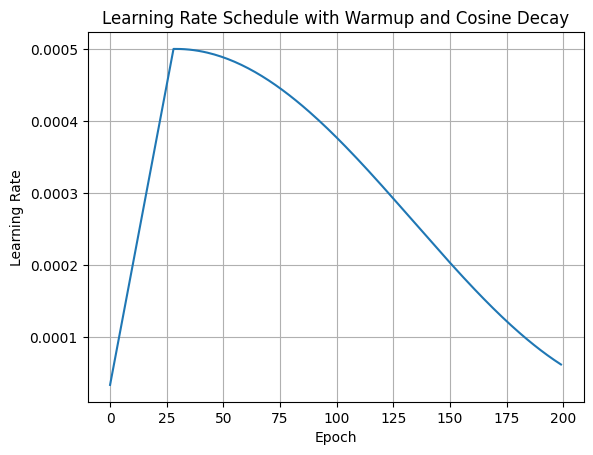

Epoch 1: Train H-F1: 0.3623, Val H-F1 full: 0.0302, Val H-F1 imu: 0.0302, Val H-F1: 0.0302, LR: 0.00001667
Epoch 2: Train H-F1: 0.5489, Val H-F1 full: 0.0312, Val H-F1 imu: 0.0302, Val H-F1: 0.0307, LR: 0.00003333
Epoch 3: Train H-F1: 0.6422, Val H-F1 full: 0.0312, Val H-F1 imu: 0.0302, Val H-F1: 0.0307, LR: 0.00005000
Epoch 4: Train H-F1: 0.6885, Val H-F1 full: 0.0341, Val H-F1 imu: 0.0302, Val H-F1: 0.0322, LR: 0.00006667
Epoch 5: Train H-F1: 0.7288, Val H-F1 full: 0.0728, Val H-F1 imu: 0.0658, Val H-F1: 0.0693, LR: 0.00008333
Epoch 6: Train H-F1: 0.7485, Val H-F1 full: 0.2915, Val H-F1 imu: 0.3314, Val H-F1: 0.3115, LR: 0.00010000
Epoch 7: Train H-F1: 0.7751, Val H-F1 full: 0.4351, Val H-F1 imu: 0.4757, Val H-F1: 0.4554, LR: 0.00011667
Epoch 8: Train H-F1: 0.7832, Val H-F1 full: 0.4769, Val H-F1 imu: 0.4642, Val H-F1: 0.4705, LR: 0.00013333
Epoch 9: Train H-F1: 0.7983, Val H-F1 full: 0.5166, Val H-F1 imu: 0.4745, Val H-F1: 0.4956, LR: 0.00015000
Epoch 10: Train H-F1: 0.8157, Val H-F

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9cf3279cf0>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/root/miniconda3/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/root/miniconda3/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/root/miniconda3/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/root/miniconda3/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [30]:
if training:
    model_args = {"imu1_channels": 128, "imu2_channels": 256, "imu1_dropout": 0.3, "imu2_dropout": 0.25,
                  "imu1_layers": 0, "imu2_layers": 0, 
                  "thm1_channels": 32, "thm2_channels": 64, "thm1_dropout": 0.25, "thm2_dropout": 0.2,
                  "thm1_layers": 0, "thm2_layers": 0, 
                  "tof1_channels": 256, "tof2_channels": 512, "tof1_dropout": 0.4, "tof2_dropout": 0.3,
                  "tof1_layers": 0, "tof2_layers": 0, 
                  "lstm_hidden_size": 128, "gru_hidden_size": 128, "gaussian_noise_rate": 0.1, "dense_channels": 32,
                  "cls_channels1": 256, "cls_dropout1": 0.2, "cls_channels2": 128, "cls_dropout2": 0.2,
                  "target_classes_num": 8, "non_target_classes_num": 10,}

    import random
    import numpy as np
    
    SEED = 0
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    for idx in range(5):
        train_model(model_args, dataset, fold_idx=idx, num_epochs=200)
        

In [31]:
1

1

In [32]:
if infer:
    model_args = {"imu1_channels": 128, "imu2_channels": 256, "imu1_dropout": 0.3, "imu2_dropout": 0.25,
                  "imu1_layers": 0, "imu2_layers": 0, 
                  "thm1_channels": 32, "thm2_channels": 64, "thm1_dropout": 0.25, "thm2_dropout": 0.2,
                  "thm1_layers": 0, "thm2_layers": 0, 
                  "tof1_channels": 256, "tof2_channels": 512, "tof1_dropout": 0.4, "tof2_dropout": 0.3,
                  "tof1_layers": 0, "tof2_layers": 0, 
                  "lstm_hidden_size": 128, "gru_hidden_size": 128, "gaussian_noise_rate": 0.1, "dense_channels": 32,
                  "cls_channels1": 256, "cls_dropout1": 0.2, "cls_channels2": 128, "cls_dropout2": 0.2,
                  "target_classes_num": 8, "non_target_classes_num": 10,}
    

    model_dicts = [
        {
            "model_path": f"best_model_fold{fold}.pt",
            "fold": fold,
        } for fold in range(5)
    ]

    
    models = list()
    folds = list()
    for model_dict in model_dicts:
        model_path = model_dict['model_path']
        model = CMIModel(**model_args).to(CUDA0)
        model.load_state_dict(torch.load(model_path))
        model = model.eval()

        models.append(model)
        folds.append(model_dict['fold'])

In [33]:
dataset.le.classes_

array(['Above ear - pull hair', 'Cheek - pinch skin',
       'Drink from bottle/cup', 'Eyebrow - pull hair',
       'Eyelash - pull hair',
       'Feel around in tray and pull out an object',
       'Forehead - pull hairline', 'Forehead - scratch', 'Glasses on/off',
       'Neck - pinch skin', 'Neck - scratch', 'Pinch knee/leg skin',
       'Pull air toward your face', 'Scratch knee/leg skin',
       'Text on phone', 'Wave hello', 'Write name in air',
       'Write name on leg'], dtype=object)

In [34]:
# metric_package = kagglehub.package_import('wasupandceacar/cmi-metric')
import metric_package
metric = metric_package.Metric()
imu_only_metric = metric_package.Metric()

def to_cuda(*tensors):
    return [tensor.to(CUDA0) for tensor in tensors]

def predict_valid(model, imu, thm, tof):
    pred = model(imu, thm, tof)
    return pred

def valid(model, valid_bar):
    with torch.no_grad():
        for imu, thm, tof, y,_ in valid_bar:
            for idx, imu_ in enumerate(imu):
                imu[idx] = imu_.to(CUDA0)
            for idx, thm_ in enumerate(thm):
                thm[idx] = thm_.to(CUDA0)
            for idx, tof_ in enumerate(tof):
                tof[idx] = tof_.to(CUDA0)
            for idx, y_ in enumerate(y):
                y[idx] = y_.to(CUDA0)

            # imu, thm, thm, y = to_cuda(imu, thm, tof, y)
            with autocast(device_type='cuda', dtype=torch.bfloat16): 
                logits = predict_valid(model, imu, thm, tof)
                # print(logits)
            metric.add(dataset.le.classes_[y.argmax(dim=1).cpu()], dataset.le.classes_[logits.argmax(dim=1).cpu()])
            imu, thm, tof = imu_only_augment(imu, thm, tof, p=1)

            with autocast(device_type='cuda', dtype=torch.bfloat16): 
                logits = model(imu, thm, tof)
            imu_only_metric.add(dataset.le.classes_[y.argmax(dim=1).cpu()], dataset.le.classes_[logits.argmax(dim=1).cpu()])

for fold, model in enumerate(models):
    valid_loader = get_fold_dataset(dataset, fold)
    valid_bar = tqdm(valid_loader, desc=f"Valid", position=0, leave=False)
    valid(model, valid_bar)

print(f"""
Normal score: {metric.score()}
# IMU only score: {imu_only_metric.score()}
""")


Normal score: 0.8617809699752081
# IMU only score: 0.790059359856141



In [35]:
y_true = []
y_pred = []
for fold, model in enumerate(models):
    valid_loader = get_fold_dataset(dataset, fold)
    valid_bar = tqdm(valid_loader, desc=f"Valid", position=0, leave=False)
    with torch.no_grad():
        for imu, thm, tof, y,_ in valid_bar:
            for idx, imu_ in enumerate(imu):
                imu[idx] = imu_.to(CUDA0)
            for idx, thm_ in enumerate(thm):
                thm[idx] = thm_.to(CUDA0)
            for idx, tof_ in enumerate(tof):
                tof[idx] = tof_.to(CUDA0)
            for idx, y_ in enumerate(y):
                y[idx] = y_.to(CUDA0)

            # imu, thm, thm, y = to_cuda(imu, thm, tof, y)
            with autocast(device_type='cuda', dtype=torch.bfloat16): 
                logits = predict_valid(model, imu, thm, tof)

            y_true.append(y.cpu().numpy())
            y_pred.append(logits.float().cpu().numpy())
oof_predictions = np.concatenate(y_pred)
df_true = np.concatenate(y_true)

In [36]:
dataset.le.classes_

array(['Above ear - pull hair', 'Cheek - pinch skin',
       'Drink from bottle/cup', 'Eyebrow - pull hair',
       'Eyelash - pull hair',
       'Feel around in tray and pull out an object',
       'Forehead - pull hairline', 'Forehead - scratch', 'Glasses on/off',
       'Neck - pinch skin', 'Neck - scratch', 'Pinch knee/leg skin',
       'Pull air toward your face', 'Scratch knee/leg skin',
       'Text on phone', 'Wave hello', 'Write name in air',
       'Write name on leg'], dtype=object)

In [37]:


target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]

indexes = []
for xx in target_gestures:
    indexes.append(list(dataset.le.classes_).index(xx))
indexes = np.array(indexes)
indexes

array([ 0,  1,  3,  4,  6,  7,  9, 10])

In [38]:
def competition_metric(y_true, y_pred) -> tuple:
    """Calculate the competition metric (Binary F1 + Macro F1) / 2"""
    
    # Binary F1: BFRB vs non-BFRB
    binary_f1 = f1_score(
        np.array([1 if xx in indexes else 0 for xx in y_true]),
        np.array([1 if xx in indexes else 0 for xx in y_pred]),
        # np.where(y_true < 7 , 1, 0),
        # np.where(y_pred < 7, 1, 0),
        zero_division=0.0,
    )
    
    # Macro F1: specific gesture classification (only for BFRB gestures)
    macro_f1 = f1_score(
        np.array([xx if xx in indexes else 99 for xx in y_true]),
        np.array([xx if xx in indexes else 99 for xx in y_pred]),
        # np.where(y_true < 7, y_true, 99),  # Map non-BFRB to 99
        # np.where(y_pred < 7, y_pred, 99),  # Map non-BFRB to 99
        average="macro", 
        zero_division=0.0,
    )
    
    # Final competition score
    final_score = 0.5 * (binary_f1 + macro_f1)
    
    return final_score, binary_f1, macro_f1


In [39]:
def grid_search_multipliers(probabilities, true_labels, values_to_try=[0.5, 1.0, 2.0]):
    """
    简单的网格搜索（适用于快速测试）
    """
    n_classes = probabilities.shape[1]
    best_f1 = 0
    best_multipliers = np.ones(n_classes)
    
    # 为每个类别尝试不同的乘数
    for class_idx in range(n_classes):
        current_best_f1 = 0
        current_best_multiplier = 1.0
        
        for multiplier in values_to_try:
            test_multipliers = best_multipliers.copy()
            test_multipliers[class_idx] = multiplier
            
            adjusted_probs = probabilities * test_multipliers
            pred_labels = np.argmax(adjusted_probs, axis=1)
            f1, overall_binary_f1, overall_macro_f1 = competition_metric(true_labels, pred_labels)
            # f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
            
            if f1 > current_best_f1:
                current_best_f1 = f1
                current_best_multiplier = multiplier
        
        best_multipliers[class_idx] = current_best_multiplier
        best_f1 = current_best_f1
        print(f"Class {class_idx}: best multiplier = {current_best_multiplier}, F1 = {current_best_f1:.4f}")
    
    return best_multipliers, best_f1

In [40]:
overall_score, overall_binary_f1, overall_macro_f1 = competition_metric(np.argmax(df_true,axis=1), np.argmax(oof_predictions,axis=1))
overall_score, overall_binary_f1, overall_macro_f1

(0.8617809699752081, 0.986962062542888, 0.7365998774075283)

In [41]:
values_to_try = np.array(range(15,26))/20


best_multipliers, best_f1 = grid_search_multipliers(oof_predictions, np.argmax(df_true,axis=1), values_to_try)
best_multipliers


Class 0: best multiplier = 1.05, F1 = 0.8618
Class 1: best multiplier = 1.0, F1 = 0.8618
Class 2: best multiplier = 0.75, F1 = 0.8618
Class 3: best multiplier = 1.1, F1 = 0.8623
Class 4: best multiplier = 1.0, F1 = 0.8623
Class 5: best multiplier = 0.8, F1 = 0.8623
Class 6: best multiplier = 1.25, F1 = 0.8628
Class 7: best multiplier = 1.0, F1 = 0.8628
Class 8: best multiplier = 1.25, F1 = 0.8629
Class 9: best multiplier = 1.0, F1 = 0.8629
Class 10: best multiplier = 1.0, F1 = 0.8629
Class 11: best multiplier = 1.05, F1 = 0.8630
Class 12: best multiplier = 0.95, F1 = 0.8631
Class 13: best multiplier = 1.05, F1 = 0.8631
Class 14: best multiplier = 1.05, F1 = 0.8632
Class 15: best multiplier = 0.95, F1 = 0.8632
Class 16: best multiplier = 0.9, F1 = 0.8634
Class 17: best multiplier = 0.75, F1 = 0.8634


array([1.05, 1.  , 0.75, 1.1 , 1.  , 0.8 , 1.25, 1.  , 1.25, 1.  , 1.  ,
       1.05, 0.95, 1.05, 1.05, 0.95, 0.9 , 0.75])

In [42]:
def avg_predict(models, imus, thms, tofs):
    outputs = []
    with autocast(device_type='cuda', dtype=torch.bfloat16):
        for model in models:
            model.eval()
            with torch.no_grad():
                pred_y = model(imus, thms, tofs)
            outputs.append(pred_y)
    return torch.mean(torch.stack(outputs), dim=0)

def split5(dataset, imu, thm, tof):
    imus = [imu[:, :, dataset.global_imu_indices[k]] for k in dataset.global_imu_indices]
    thms = [thm[:, :, dataset.global_thm_indices[k]] for k in range(1, 6)]
    tofs = [tof[:, :, dataset.global_tof_indices[k]] for k in range(1, 6)]
    return imus, thms, tofs

def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:

    sequence_reverse = sequence.to_pandas().copy()
    sequence_reverse = sequence_reverse[::-1]
    sequence_reverse = sequence_reverse.reset_index(drop=True)
    sequence_reverse = pl.from_pandas(sequence_reverse)
    
    imu, thm, tof = dataset.full_dataset.inference_process(sequence_reverse)
    imus, thms, tofs = split5(dataset.full_dataset, imu, thm, tof)
    with torch.no_grad():
        for idx, imu in enumerate(imus):
            imus[idx] = imu.to(CUDA0)
        for idx, thm in enumerate(thms):
            thms[idx] = thm.to(CUDA0)
        for idx, tof in enumerate(tofs):
            tofs[idx] = tof.to(CUDA0)
        pred_y = avg_predict(models, imus, thms, tofs)
    pred_y = pred_y.cpu().float().numpy()
    pred_y = pred_y*best_multipliers
    return dataset.le.classes_[np.argmax(pred_y)]
    # return pred_y



In [26]:
import kaggle_evaluation.cmi_inference_server

inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '../input/cmi-detect-behavior-with-sensor-data/test.csv',
            '../input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )

In [27]:
pd.read_parquet('submission.parquet')

,sequence_id,gesture
0,SEQ_000011,Eyelash - pull hair
1,SEQ_000001,Eyebrow - pull hair
